In [1]:
import logging
import pathlib
import shutil
import sys
import csv
import os
import itertools
from tqdm import tqdm
logging.basicConfig()

import scipy
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_validate
from matplotlib import pyplot as plt
from tdc import Evaluator
import numpy as np
import seaborn as sb

from rdkit import Chem
from rdkit.Chem import MACCSkeys

sys.path.append('..')
from sbap.sdf import ChemblSdfReader
from sbap.featurizers.prolif_smina import SminaDockingPersistenceHandler, SminaConfig, DockedProlifFingerprintFeaturizer, SminaDockingScoreFeaturizer

In [2]:
sdf_file = pathlib.Path("../molecules/CYP2C9_IC50_CHEMBL_data.sdf")
protein_pdb_file = pathlib.Path("../molecules/4nz2_CYP2C9_cleaned.pdb")
docked_ligands_target_directory = pathlib.Path("../molecules/CYP2C9_bis")

config = SminaConfig(
    center_x=48.254, center_y=11.175, center_z=-20.580, size_x=30, size_y=30, size_z=30, exhaustiveness=8,
)
persistent_docking_handler = SminaDockingPersistenceHandler.create(
    smina_config=config,
    docked_ligands_target_directory=str(docked_ligands_target_directory),
    logging_level=logging.INFO,
)
fingerprint_featurizer = DockedProlifFingerprintFeaturizer.create(
    logging_level=logging.INFO,
)
docking_score_featurizer = SminaDockingScoreFeaturizer(logging.INFO)

# persistent_docking_handler.dock(protein_pdb_file, sdf_file, starting_batch=697, batch_size=1)

## Transformacja nr 0 (opcjonalna) - dodaj MACCS

In [3]:
def get_input_data(include_maccs=False):
    fingerprint_featurizer.fit(protein_pdb_file, docked_ligands_target_directory)
    X, y = fingerprint_featurizer.transform(protein_pdb_file, docked_ligands_target_directory)
    if include_maccs:
        # sdf_reader = Chem.rdmolfiles.SDMolSupplier(str(sdf_file))
        reader = ChemblSdfReader()
        molecules = reader.parse(sdf_file)
        maccs = []
        cnt = 0
        labels_csv = os.path.join(docked_ligands_target_directory, 'labels.csv')
        with open(labels_csv, 'r') as file:
            for result_id, score, label, cdId in csv.reader(file):
                number = int(cdId[1:-1])
                while molecules[cnt]['cdId'] != number:
                    cnt += 1
                mol = Chem.rdmolfiles.MolFromMolBlock(molecules[cnt]['mol'])
                fp = MACCSkeys.GenMACCSKeys(mol).ToBitString()
                maccs.append(MACCSkeys.GenMACCSKeys(mol))
                cnt += 1
        maccs_x = np.array(maccs, dtype='i')
        print(f'maccs.shape = {maccs_x.shape}')
        X = np.concatenate((X, maccs_x), axis=1)
    return X, y

In [44]:
X_raw, Y_raw = get_input_data(include_maccs=True)
print(f'input shape: {X_raw.shape}')

  0%|          | 0/1672 [00:00<?, ?it/s]

  0%|          | 0/1672 [00:00<?, ?it/s]

maccs.shape = (1672, 167)
input shape: (1672, 393)


## Transformacja nr 1 - przekształć y na skalę logarytmiczną

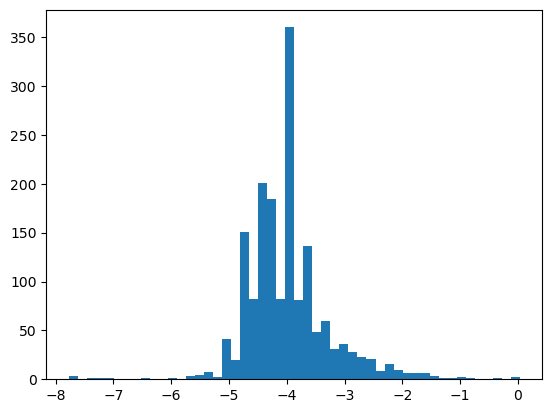

In [45]:
dataset_siz = X_raw.shape[0]
y = np.array(Y_raw, dtype='f')
y = -np.log10(y)
count, bins, _ = plt.hist(y, bins=50)

Czy liczba zapalonych bitów fingerprintu koreluje z docking score? Chyba tak

## Transformacja nr 2 
### usuń punkty, dla których docking score jest niespodziewanie mały

old shape: (1672, 393)
new shape: (1666, 393)


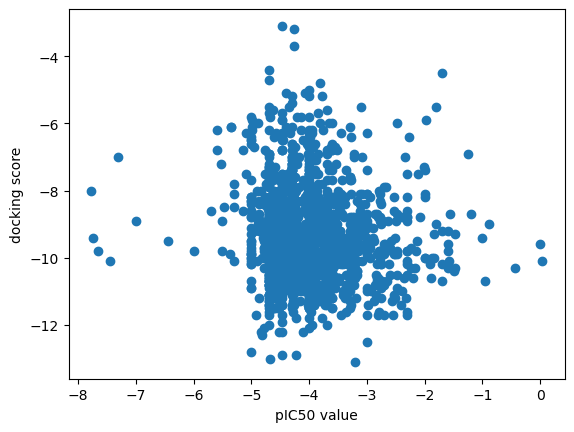

In [46]:
X = X_raw
print(f'old shape: {X.shape}')
good_indices = np.argwhere(X[:, 0] < -2).flatten()
X = X[good_indices, :]
y = y[good_indices]
print(f'new shape: {X.shape}')
plt.scatter(y, X[:, 0])
plt.xlabel('pIC50 value')
plt.ylabel('docking score')
plt.show()

## Transformacja nr 3 (opcjonalna)
### usuń bity, które są zapalone tylko dla kilku (<CUTOFF_THRESHOLD) ligandów

In [47]:
def truncate(X, Y, CUTOFF_THRESHOLD=10):
    sums = np.sum(X, axis=0)
    good_idces = [0] + list(np.argwhere(sums > CUTOFF_THRESHOLD).flatten())
    print(f'now every row has {len(good_idces)} bits')
    X_trunc = X[:, good_idces]
    return X_trunc, Y

X_trunc, y_trunc = truncate(X, y)

now every row has 236 bits


## Transformacja nr 4 (opcjonalna)
### usuń część danych tak aby rozkład danych bardziej przypominał rozkład normalny

(1139, 236)
(1139,)


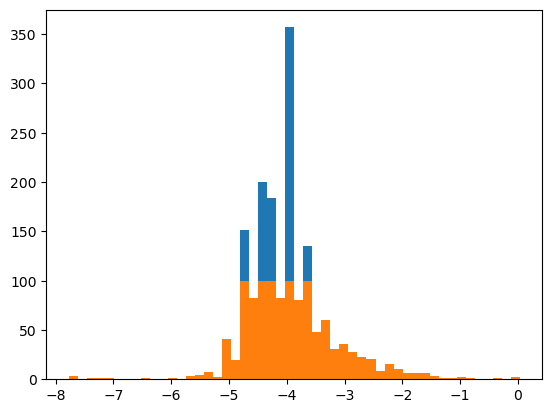

In [50]:
def pseudonormalize(X, Y, THRESHOLD=100):
    n_bins = 50
    y_min = np.min(Y)
    y_max = np.max(Y) + 0.0001
    limits = []

    good_indices = []
    for i in range(51):
        limits.append(y_min + (i * (y_max - y_min) / n_bins))
    for i in range(50):
        bin_indices = np.argwhere(np.logical_and(Y >= limits[i], Y < limits[i+1])).flatten()
        if len(list(bin_indices)) > THRESHOLD:
            bin_indices = bin_indices[:THRESHOLD]
        good_indices = good_indices + list(bin_indices)
    tX = X[good_indices]
    tY = Y[good_indices]

    print(tX.shape)
    print(tY.shape)
    plt.hist(Y, bins=50)
    plt.hist(tY, bins=50)
    plt.show()
    return tX, tY

X_norm, y_norm = pseudonormalize(X_trunc, y_trunc, 100)

# Porównanie różnych modeli regresji

In [51]:
rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')

In [52]:
"""
uses 5-cross validation to estimate model
"""
def evaluate_regression_model(model, X, y):
    scoring = ['neg_mean_absolute_error', 'r2']
    results = cross_validate(estimator=model, X=X, y=y, cv=5, scoring=scoring)
    return np.mean(results['test_r2']) + np.mean(results['test_neg_mean_absolute_error'])

def test_regression_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)

    fig, ax = plt.subplots()
    ax.axline((0, 0), slope=1)
    
    predictions = model.predict(x_train)  
    rmse_score = rmse(y_train, predictions)
    mae_score = mae(y_train, predictions)
    r2_score = r_squared(y_train, predictions)
    print(f'on train set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_train, predictions)

    predictions = model.predict(x_test) 
    rmse_score = rmse(y_test, predictions)
    mae_score = mae(y_test, predictions)
    r2_score = r_squared(y_test, predictions)
    print(f'on test set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_test, predictions)
    plt.show()

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge

# you can try multiple configurations
regression_model_list = [
    (RandomForestRegressor, {
        'n_estimators': [300, 500, 800], 
        'min_samples_leaf': [2, 4, 8], 
        'max_features': ['log2', 'sqrt', None]
    }),
    (MLPRegressor, {
        'hidden_layer_sizes': [(100,), (300,), (256, 128), (128, 64, 32), (100, 100)], 
        'activation': ['logistic', 'tanh', 'relu'],
        'early_stopping': [True, False]
    }),
    (Ridge, {
        'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
    }),
]

In [54]:
def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values()))

scores = []
best_score = -10.0
best_params = ()
best_model_type = None

x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2)

for model_type in regression_model_list:
    for params in tqdm(my_product(model_type[1])):
        model = model_type[0](**params)
        score = evaluate_regression_model(model, x_train, y_train)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_model_type = model_type[0]
            best_params = params
    print(f'done with {model_type[0]}')
print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')

11it [00:55,  5.01s/it]


KeyboardInterrupt: 

best_model_type = <class 'sklearn.ensemble._forest.RandomForestRegressor'>, best_params = {'n_estimators': 300, 'min_samples_leaf': 2, 'max_features': 'sqrt'}, best_score = -0.4240888100774743
on train set: RMSE, MAE, R2 = 0.3618097369807259, 0.2433895827327144, 0.8101845789440056
on test set: RMSE, MAE, R2 = 0.7803753083151169, 0.548934416136261, 0.23926608795768567


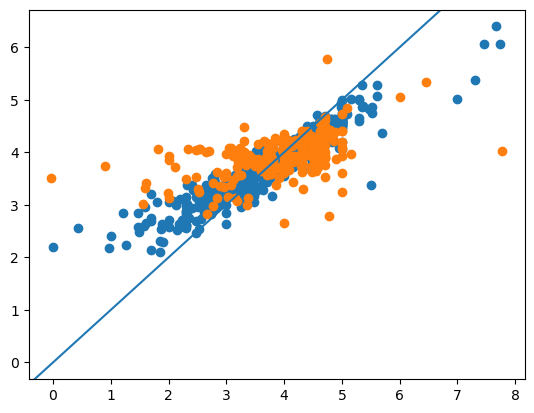

In [41]:
print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')
model = best_model_type(**best_params)
test_regression_model(model, x_train, x_test, y_train, y_test)

## Variable importance

max contribution: 0.037498949451763526, min contribution: 3.1263732505746925e-05
the docking score parameter contributed 0.001078445487610113
on average, a SIFT parameter contributed 0.0034352134388259303
on average, a MACCS parameter contributed 0.005014769598129168


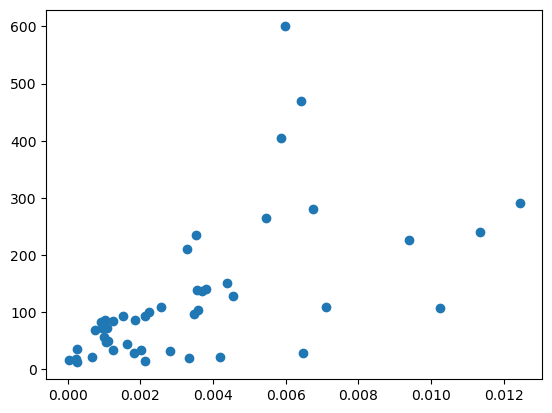

In [24]:
np.set_printoptions(precision=4, suppress=True)
importance = model.feature_importances_
importance_sift = importance[1:-167]
sum_sift = np.sum(X_norm[:, 1:-167], axis=0)
plt.scatter(importance_sift, sum_sift)
print(f'max contribution: {np.max(importance)}, min contribution: {np.min(importance)}')
print(f'the docking score parameter contributed {importance[0]}')
print(f'on average, a SIFT parameter contributed {np.mean(importance_sift)}')
print(f'on average, a MACCS parameter contributed {np.mean(importance[-167:])}')
plt.show()

# Porównanie modeli klasyfikacji binarnej

In [57]:
def get_binary_classification_data(X, y, threshold = -4.0):
    high_pic50 = np.argwhere(y > threshold).flatten()
    yb = np.zeros(y.shape)
    yb[high_pic50] = 1.0
    yb = np.array(yb, dtype='i')
    print(f'fraction of 1\'s: {sum(yb) / len(yb)}')
    return X, yb

In [58]:
acc = Evaluator(name = 'Accuracy')
prec = Evaluator(name = 'Precision')
recall = Evaluator(name = 'Recall')

def evaluate_classification_model(model, X, yb):
    scoring = ['accuracy', 'precision', 'recall']
    results = cross_validate(estimator=model, X=X, y=yb, cv=5, scoring=scoring)
    return np.mean(results['test_accuracy']) + 3 * np.mean(results['test_precision']) + 5 * np.mean(results['test_recall'])


def test_classification_model(model, xb_train, xb_test, yb_train, yb_test):
    model.fit(xb_train, yb_train)

    predictions = model.predict(xb_train)  
    print(predictions[:30])
    print(yb_train[:30])
    acc_score = acc(yb_train, predictions)
    prec_score = prec(yb_train, predictions)
    recall_score = recall(yb_train, predictions)
    print(f'on train set: Accuracy, Precision, Recall = {acc_score}, {prec_score}, {recall_score}')

    predictions = model.predict(xb_test) 
    print(predictions[:30])
    print(yb_test[:30])
    acc_score = acc(yb_test, predictions)
    prec_score = prec(yb_test, predictions)
    recall_score = recall(yb_test, predictions)
    print(f'on test set: Accuracy, Precision, Recall = {acc_score}, {prec_score}, {recall_score}')

In [59]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

classification_model_list = [
    (RandomForestClassifier, {}),
    (AdaBoostClassifier,     {'n_estimators': [15, 31, 61]}),
    # (SVC,                    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.3, 1.0, 3.0]}),
    (SVC,                    {'kernel': ['poly', 'sigmoid'], 'C': [0.3, 1.0, 3.0]}),
    (MLPClassifier,          {'hidden_layer_sizes': [80, 50], 'alpha': [0.3, 1.0, 3.0]}),
    (LogisticRegression,     {'penalty': ['l1', 'l2'], 'C': [0.1, 0.3], 'solver': ['liblinear']}),
]

In [61]:
def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values()))

best_params_dict = {}

for threshold in [-4.5, -4.25, -4.0, -3.75]:
    scores = []
    best_score = -10.0
    best_params = ()
    best_model_type = None
    X, yb = get_binary_classification_data(X_norm, y_norm, threshold)
    print(X.shape)
    xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)

    for model_type in classification_model_list:
        for params in my_product(model_type[1]):
            model = model_type[0](**params)
            score = evaluate_classification_model(model, xb_train, yb_train)
            scores.append(score)
            if score > best_score:
                best_score = score
                best_model_type = model_type[0]
                best_params = (model_type[0], params)
    print(f'best_model_type = {best_model_type}, best_params = {best_params}, best_score = {best_score}')
    best_params_dict[threshold] = best_params

fraction of 1's: 0.7664618086040387
(1139, 236)
best_model_type = <class 'sklearn.ensemble._forest.RandomForestClassifier'>, best_params = (<class 'sklearn.ensemble._forest.RandomForestClassifier'>, {}), best_score = 8.108939639822635
fraction of 1's: 0.6049165935030729
(1139, 236)
best_model_type = <class 'sklearn.svm._classes.SVC'>, best_params = (<class 'sklearn.svm._classes.SVC'>, {'kernel': 'poly', 'C': 0.3}), best_score = 7.455083167275321
fraction of 1's: 0.4433713784021071
(1139, 236)
best_model_type = <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>, best_params = (<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>, {'hidden_layer_sizes': 80, 'alpha': 0.3}), best_score = 5.6705173686867685
fraction of 1's: 0.3713784021071115
(1139, 236)
best_model_type = <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>, best_params = (<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>, {'hidden_layer_sizes': 80, 'a

In [55]:
print(best_params_dict)

for threshold, best_params in best_params_dict.items():
    X, yb = get_binary_classification_data(threshold)
    xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)
    best_model_type = best_params[0]
    params = best_params[1]
    print(f'best_model_type: {best_model_type}')
    print(f'best params: {best_params}')
    model = best_model_type(**params)
    test_classification_model(model, xb_train, xb_test, yb_train, yb_test)

NameError: name 'best_params_dict' is not defined

In [33]:
X, yb = get_binary_classification_data(11.5)
xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)
model = MLPRegressor(hidden_layer_sizes=[80, 50], alpha=8.0)
test_classification_model(model, xb_train, xb_test, yb_train, yb_test)

fraction of 1's: 0.4362017804154303
[0.18484047 0.68568137 0.29016993 0.4026798  0.28132411 0.46623213
 0.63981223 0.45290765 0.34995989 0.50596495 0.32664681 0.35668862
 0.51757553 0.35654735 0.26682023 0.515769   0.30799824 0.35542708
 0.33709394 0.32141587 0.51949575 0.56005981 0.3279393  0.55210631
 0.49773555 0.2147258  0.49461598 0.71946293 0.25491235 0.42601704]
[0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0]
on train set: Accuracy, Precision, Recall = 0.7142857142857143, 0.7701863354037267, 0.5145228215767634
[0.30984451 0.36485503 0.50240647 0.60651687 0.44985735 0.29764388
 0.39638695 0.52910322 0.30742195 0.66053534 0.25728524 0.389666
 0.54135237 0.67725063 0.36065823 0.34263563 0.50774932 0.451111
 0.51556557 0.39311211 0.39631509 0.28315101 0.57519202 0.64197497
 0.35111221 0.48398821 0.2793325  0.4371189  0.54654274 0.3158102 ]
[0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0]
on test set: Accuracy, Precision, Recall = 0.5555555555555556, 0.3870